# Potato Disease Classification

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

## Problem Statement

Farmers who grow potatoes are facing economic loss every year because of various diseases that can happen to a potato plant. There are two common diseases known as early blight and late blight. Early blight is caused by a fungus and late blight is caused by a specific microorganism.If farmers can detect this disease early and apply some treatment then it prevents a lot of waste and economic loss. The treatments for late blight and early blight are different so it is important to accurately identify what kind of disease is there in that potato plant.

## Our Solution

Build a machine learning model that can classify various potato plant diseases by just looking at the image which can be further be reduced in size usnig tensorflow-lite so that we can use it edge device to capture potato leaf images and identify the unhealthy leaves.

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

**dataset.take(1) will get one batch comprising of tuple ( images,labels)**

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

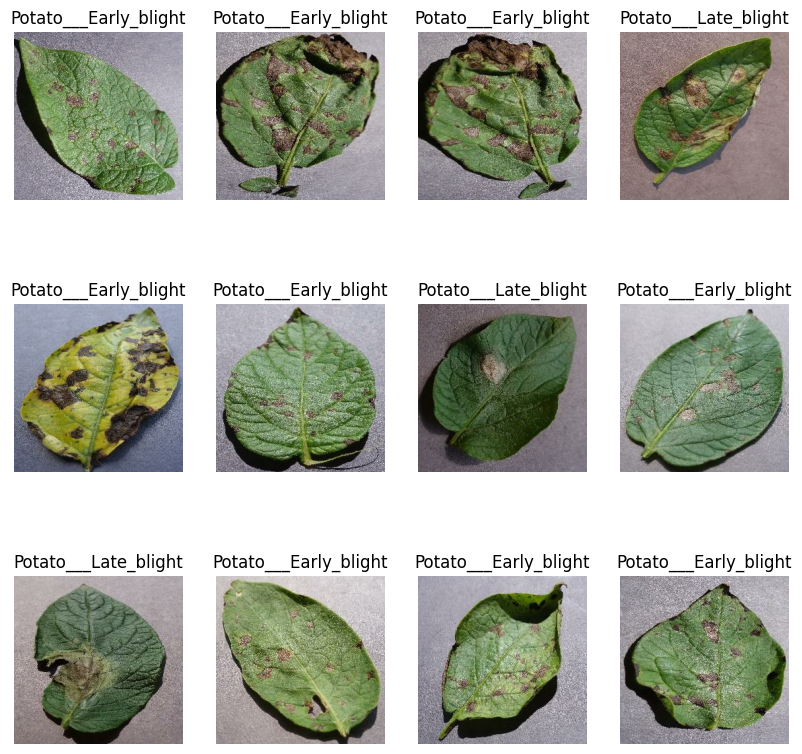

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training(80%)
2. Validation: Dataset to be tested against while training(10%)
3. Test: Dataset to be tested against after we trained a model(10%)

#### Total Number of batches

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

### Building a Customized function to get train,test and validation dataset

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds) # It is 68 in our case
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size) # It is 54 in our case
    val_size = int(val_split * ds_size) # It is 6 in our case
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset(Required to better utilization of CPU and cache memory)

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #hide memory latencies by fetching data proactively before the processor needs the data.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Architecture


**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks**

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 28s 508ms/step - loss: 0.9020 - accuracy: 0.4688 - val_loss: 0.8086 - val_accuracy: 0.5156
Epoch 2/50
54/54 [==============================] - 28s 521ms/step - loss: 0.6843 - accuracy: 0.6481 - val_loss: 0.6191 - val_accuracy: 0.6771
Epoch 3/50
54/54 [==============================] - 28s 522ms/step - loss: 0.4181 - accuracy: 0.8027 - val_loss: 0.3353 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 26s 490ms/step - loss: 0.3972 - accuracy: 0.8466 - val_loss: 0.3947 - val_accuracy: 0.8594
Epoch 5/50
54/54 [==============================] - 27s 506ms/step - loss: 0.3231 - accuracy: 0.8715 - val_loss: 0.2718 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 27s 506ms/step - loss: 0.1653 - accuracy: 0.9381 - val_loss: 0.3009 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 27s 497ms/step - loss: 0.1463 - accuracy: 0.9404 - val_loss: 0.1102 - val_accuracy: 0.9740

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 134ms/step - loss: 0.0368 - accuracy: 0.9844


**You can see above that we get 98.83% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [29]:
scores

[0.03676139563322067, 0.984375]

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Below graphs shows the accuracy and loss in training and validation in each epoch

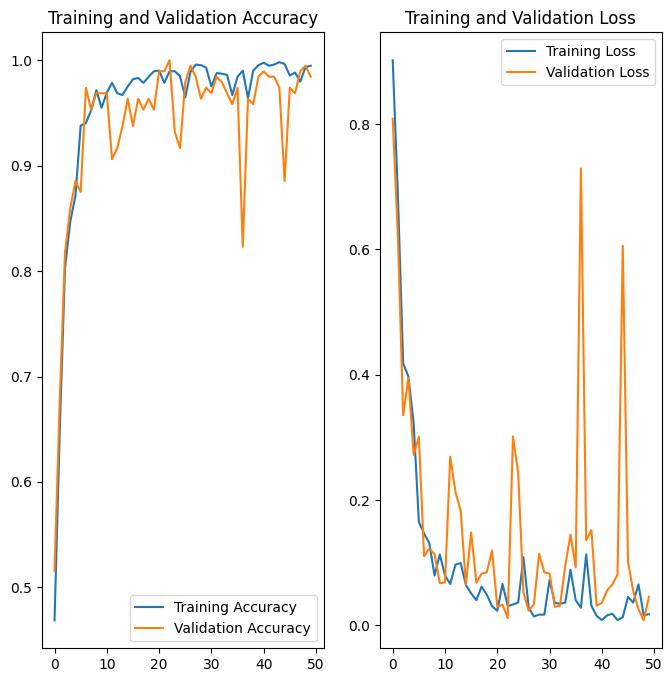

In [102]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Scores is just a list containing loss and accuracy value

### Saving the Model
We append the model to the list of models as a new version

In [31]:
import os

model.save(f"models/1")

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets


### Convert saved model to tf lite

In [32]:
converter = tf.lite.TFLiteConverter.from_saved_model("models/1")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

2024-01-19 02:48:23.287724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-19 02:48:23.287739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-19 02:48:23.288035: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: models/1
2024-01-19 02:48:23.289455: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-19 02:48:23.289459: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: models/1
2024-01-19 02:48:23.291992: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-01-19 02:48:23.293046: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-19 02:48:23.333677: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: models/1
2024-01-19 02:48:23.345580: I t

### Now as tflite model is in flatbuffer format we should see tensors to input our test data in it

In [33]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [103]:
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 256 256   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 3]
Output Type: <class 'numpy.float32'>


### Printing first 5 batches of test dataset

In [39]:
count = 0
for image, label in test_ds.take(5):
    print(label)
    
print(count)

tf.Tensor([1 0 1 1 2 1 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 1 0 2 1 0 0 1 1 0 1 0], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 0 2 0 1 1 1 1 0 1 1 0 0 1 2 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 2 1 0 1 0 0 0 0 0 0 1 1 0 1 2 1 1 0 1 2 2 1 0 1 0 0 1 2 1 1], shape=(32,), dtype=int32)
tf.Tensor([1 0 1 1 1 0 0 0 0 2 1 1 1 0 0 1 1 1 2 1 1 0 0 0 1 1 0 0 0 1 0 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 0 2 1 0 1 1 0 0 0 1 1 0 1 1 0 1 1], shape=(32,), dtype=int32)
0


In [40]:
for image, label in test_ds.unbatch().take(5):
    print("image shape",image.shape)
    print("label",label)

image shape (256, 256, 3)
label tf.Tensor(0, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(1, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(0, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(1, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(1, shape=(), dtype=int32)


## Fitting our tflite model on test dataset, storing output labels in list and visualizing also

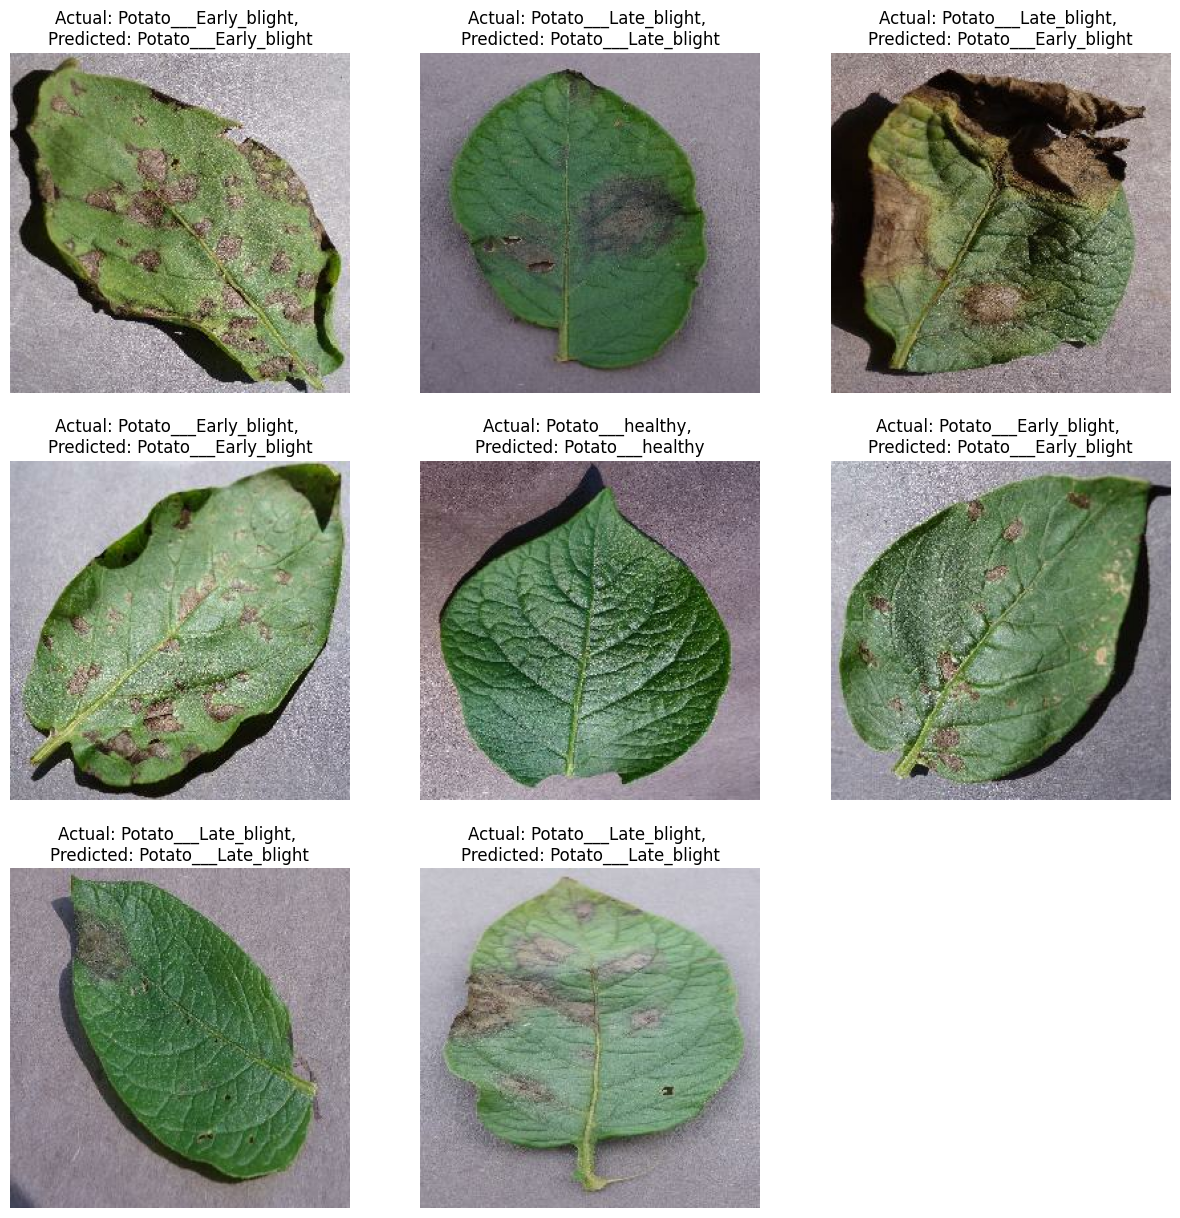

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_ds has a length greater than 9
num_images = min(len(test_ds), 9)
num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

plt.figure(figsize=(15, 15))

predicted_labels = []  # Initialize as empty lists
actual_labels = []

for i, (images, labels) in enumerate(test_ds.unbatch()):
    ax = plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(images.numpy().astype('uint8'))

    # Assuming interpreter, input_index, and output_index are defined earlier
    interpreter.set_tensor(input_index, [images])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    pred_l = class_names[np.argmax(output[0])]
    actual_l = class_names[labels.numpy()]
    
    predicted_labels.append(np.argmax(output[0]))
    actual_labels.append(labels.numpy())
    
    plt.title(f"Actual: {actual_l}, \nPredicted: {pred_l}")
    plt.axis("off")

    if i+1 == num_images:  # Stop when plotted the desired number of images
        break

plt.show()

In [97]:
predicted_labels[:10]

[1, 0, 1, 1, 1, 0, 0, 0]

In [98]:
actual_labels[:10]

[1, 0, 1, 1, 1, 0, 0, 0]

In [45]:
comparison_vector = np.array(predicted_labels) == np.array(actual_labels)
comparison_vector[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## Accuracy of tflite model

In [47]:
accuracy = comparison_vector.mean()
accuracy

0.984375

This shows that accuracy of our tflite model is around 99% which is considered to be pretty good. Now we can deploy this model to GCP (Google Cloud Platform) our an edge device for further usage

# Conclusion

We have shown that our model can be converted to tflite model with approximately same accuracy achieved( 98.43%). Now we can deploy this tflite model on an edge device like arduino and predict the condition of the potato leaves (healthy or late-blight or early-blight).